In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
!pip install -q segmentation_models_pytorch
import segmentation_models_pytorch as smp
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.checkpoint as C
import torchvision.transforms.functional as fn
import torchvision.transforms as T
import matplotlib.pyplot as plt
!pip install -q torchsummary
from torchvision import models
from torchsummary import summary

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')    
device

device(type='cuda')

In [44]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/train'
ids = os.listdir(train_path)
os.makedirs('/kaggle/data_dir/',exist_ok=True)

In [3]:
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

In [ ]:
for i in tqdm(ids):
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    mask=np.load(f'{train_path}/{i}/human_pixel_masks.npy')
    directory = f'/kaggle/data_dir/{i}/'
    os.makedirs(directory, exist_ok=True)
    np.save(os.path.join(directory, 'false.npy'), image)
    np.save(os.path.join(directory, 'mask.npy'), mask)

In [7]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
        self.ids = os.listdir(self.path)
    def __len__(self):
        return len(self.ids)
    def __getitem__(self,idx):
        id = ids[idx]
        image = np.load(f'{self.path}/{id}/false.npy')
        mask = np.load(f'{self.path}/{id}/mask.npy')
        image = torch.from_numpy(image)
        image = torch.moveaxis(image,-1,0)
        mask = torch.from_numpy(mask)
        mask=torch.moveaxis(mask,-1,0)
        return image,mask.float()

In [8]:
train_dataset = CustomDataset('/kaggle/data_dir/')

In [9]:
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True)

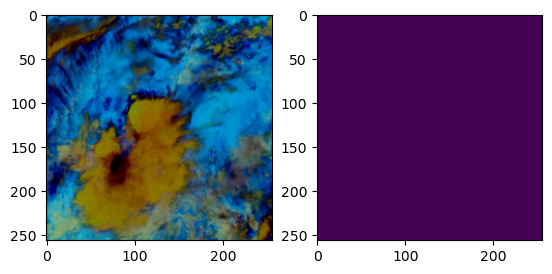

In [10]:
test_image , test_mask = next(iter(train_dataloader))
test_image = torch.moveaxis(test_image,1,-1)
test_mask = torch.moveaxis(test_mask,1,-1)
ax , fig = plt.subplots(1,2)
fig[0].imshow(test_image[2])
fig[1].imshow(test_mask[2])

In [ ]:
model = smp.UnetPlusPlus(encoder_name='resnet101',encoder_weights='imagenet',in_channels=3,classes=1,decoder_attention_type='scse',activation="sigmoid")
model.to(device)

In [12]:
def Dice_loss(pred, mask):
    
    smooth = 1e-6  # Smoothing factor to avoid division by zero
        
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)

    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient

    return dice_loss

    

In [13]:
os.makedirs('/kaggle/working/savedmodel')

In [ ]:
learning_rate = 0.005
losses = []
epochs=50
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',patience = 4, factor = 0.31622776601, verbose = True)
best_score = 0
best_dice_epoch = 0
for epoch in range(epochs):
    batch_dice_score = 0
    net_dice_loss = 0
    if(epoch - best_dice_epoch > 15):
        print(f'early stopped due to no improvement in last 15 epochs')
        torch.save(model.state_dict(),f'/kaggle/working/savedmodel/last_run_epoch.pt')
        break
    cnt = 0
    for image , mask in tqdm(train_dataloader):
        image,mask = image.to(device), mask.to(device)
        optimizer.zero_grad()
        pred = model(image)
        loss = Dice_loss(pred,mask)
        loss.backward()
        optimizer.step()
        batch_dice_score += (1-loss)
        net_dice_loss +=loss
        cnt+=1
    net_dice_loss=net_dice_loss/cnt
    losses.append(net_dice_loss)
    print(f'at {epoch}th the dice loss is {net_dice_loss}')
    if(best_score<batch_dice_score):
        if(epoch>7):
            torch.save(model.state_dict(),f'/kaggle/working/savedmodel/{epoch}th_epoch.pt')
        best_score = batch_dice_score
        best_dice_epoch = epoch
    

In [ ]:
model = smp.UnetPlusPlus(encoder_name='resnet101',encoder_weights='imagenet',in_channels=3,classes=1,decoder_attention_type='scse',activation="sigmoid")
model.load_state_dict(torch.load('/kaggle/input/contrail-detection-run2/9th_epoch.pt'))
model.to(device)

In [6]:
train_path = '/kaggle/input/google-research-identify-contrails-reduce-global-warming/test'
ids=['1000834164244036115','1002653297254493116']

In [7]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
    Returns: run length encoding as list
    """

    dots = np.where(
        x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x: # non-empty list
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s


def rle_decode(mask_rle, shape=(256, 256)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if mask_rle != '-': 
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

In [15]:
import pandas as pd
from pathlib import Path
data_path = Path('/kaggle/input/google-research-identify-contrails-reduce-global-warming')
submission = pd.read_csv(data_path / 'sample_submission.csv', index_col='record_id')

for i in ids:
    band15= np.load(f'{train_path}/{i}/band_15.npy')
    band14= np.load(f'{train_path}/{i}/band_14.npy')
    band11= np.load(f'{train_path}/{i}/band_11.npy')
    r= normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g= normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b= normalize_range(band14, _T11_BOUNDS)
    image = np.clip((np.stack([r,g,b],axis=2)),0,1)
    image = image[...,4]
    image = torch.tensor(image).to(device)
    image = torch.moveaxis(image,-1,0)
    image = torch.unsqueeze(image,0)
    pred = model(image)
    pred = pred.detach().to('cpu')
    pred = pred.numpy()
    pred=np.squeeze(pred,(0,1))
    pred = np.c_[np.unravel_index(np.argpartition(pred.ravel(),-100)[-100:],pred.shape)]
    mask = np.zeros((256, 266))
    mask[pred[:, 0], pred[:, 1]] = 1
    # notice the we're converting rec to an `int` here:
    submission.loc[int(i), 'encoded_pixels'] = list_to_string(rle_encode(mask))

submission.head()

,encoded_pixels
record_id,
1000834164244036115,33 1 40 1 72 8 96 4 130 7 141 2 197 4 213 3 22...
1002653297254493116,1 1 63 6 90 4 98 8 113 6 123 12 142 2 187 1 20...


In [16]:
submission.to_csv('submission.csv')

model.eval()